# Homework 6
Pedro Augusto Januzzi Guerra

# Questions

1. Use IPUMS CPS (both at www.ipums.org) to construct a distribution of earnings across US individuals and compare the US data with model data from Homework 5.
    - a. Explain how and why you picked the particular sample that you did.
    - b. Discuss the main differences and similarities between the data and the model.
    - c. Vary parameters in ways that can narrow the differences found in part b.

2. (Optional) Repeat the exercise with IPUMS USA from the American Community Survey.

---
Copy code from HW 5 and compute the distribution of earnings:

In [1]:
# Packages used
using LinearAlgebra, Plots, Distributions, PrettyTables, NLsolve, ForwardDiff,CSV, GZip, CodecZlib, DataFrames, Chain, Tidier, StatsPlots

HW 5 part (a):

In [2]:
function Tauchen(sigma, mu, pts, rho)
    scale = 1;  # scale parameter
    upper_bound = scale*sigma/sqrt(1 - rho^2); # note this is the same as in hw 4, but in this question rho=0
    lower_bound = -upper_bound;
    grid_l = LinRange(lower_bound, upper_bound, pts);

    delta_l = (upper_bound - lower_bound) / (pts - 1)
    P = zeros(pts, pts)
    dist = Normal(mu, sigma)

    for i = 1:pts
        P[i,1] = cdf(dist, (grid_l[1] - (1 - rho) * mu .- rho * grid_l[i] + delta_l / 2))
        P[i, end] = 1 - cdf(dist, (grid_l[end] - (1 - rho) * mu - rho * grid_l[i] - delta_l / 2))

        for j = 2:(pts-1)
            P[i,j] = cdf(dist, (grid_l[j] + delta_l / 2 - (1 - rho) * mu - rho * grid_l[i])) -
                        cdf(dist, (grid_l[j] - delta_l / 2 - (1 - rho) * mu - rho * grid_l[i]))
        end
    end
    grid_l = exp.(grid_l);

    if rho == 0
        grid_l = LinRange(0.3,1,pts);
        P = ones(pts,pts)/pts;
    end

    return P, grid_l
end

Tauchen (generic function with 1 method)

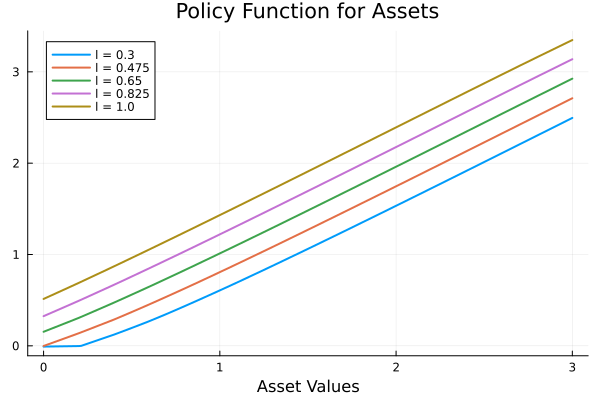

In [3]:
σ = 0.05;  # st dev of shocks
mean = 0;   # mean of shocks
N = 5;  # number of grid points
ρ_1 = 0; # persistence for question 1

# Compute transition matrix and grid for labor
T, l_grid = Tauchen(σ,mean,N,ρ_1);

β = 0.95; # discount factor
δ = 0.04; # depreciation rate
α = 0.33; # output elasticity of capital:: Cobb-Douglas
μ = 2; # relative risk aversion coefficient
γ = 50000; # parameter for penalty function:::: it's a little of an overkill, could be smaller
ϕ = 0; # borrowing constraint

a_lb = ϕ;
a_ub = 4;
n = 20;
a_grid = LinRange(a_lb,a_ub,n);

# Values for prices (guesses)
r_max = (1/β)-1; # maximum interest rate
r_g = 0.8*r_max; # guess for interest rate
w_g = (1-α)*(α/(r_g+δ))^(α/(1-α)); # guess for wage

# Psi function::: same idea as HW 4
function psi(i,a,grid_a)
    n = length(grid_a);
    if i == 1
        if a >= grid_a[i] && grid_a[i+1] >= a
            ψ = (grid_a[i+1] - a)/(grid_a[i+1] - grid_a[i]);
        else        
            ψ = 0;
        end
        
    elseif i == n   
        if a >= grid_a[i-1] && grid_a[i] >= a    
            ψ = (a - grid_a[i-1])/(grid_a[i] - grid_a[i-1]);
        else        
            ψ = 0;        
        end
        
    else        
        if a >= grid_a[i-1] && grid_a[i] >= a            
            ψ = (a - grid_a[i-1])/(grid_a[i] - grid_a[i-1]);            
        elseif a > grid_a[i] && grid_a[i+1] >= a
            ψ = (grid_a[i+1] - a)/(grid_a[i+1] - grid_a[i]);           
        else 
            ψ = 0;           
        end        
    end

    return ψ
end

# Function to compute the assets for tomorrow
function asset(θ,x,y)

    idx_labor = findfirst(z -> z == y, l_grid); # get the index (position in the grid) in the of the labor endowment
    
    a = 0;
    for i=1:n
        a += θ[i,idx_labor]*psi(i,x,a_grid) # compute assets for tomorrow using the approximation
    end
   
    return a
 end

 # Function to compute the residual
 function residuals(θ,k,l)

    idx_labor = findfirst(z -> z==l,l_grid);
    c(x,y) = w_g*y + (1+r_g)*x - asset(θ,x,y); # function that computes consumption today
    aux1 = (c(k,l))^(-μ) - γ*min(asset(θ,k,l),0)^2; # first part of residual equation
    aux2 = 0;
    for i=1:N
        aux2 += T[idx_labor,i]*(c(asset(θ,k,l),l_grid[i]))^(-μ); # second part of residual equation
    end
    # Residual
    R = aux1 - β*(1+r_g)*aux2; # residual equation

    return R
 end

# Function to solve the integral using quadratures
function quadrature(f,start,endd,n)

    d = n-1;
    delta = (endd-start)/(n-1);
    quad_pts = zeros(n);
    quad_wght = zeros(n);
    for i=1:n   
        quad_pts[i] = start + (i-1)*delta;
    end

    quad_wght[1] = delta/2;
    quad_wght[n] = delta/2;
    
    for i=2:d
        quad_wght[i] = delta;
    end

    intt = 0;
    for i=1:n
        intt += quad_wght[i]*f(quad_pts[i]);
    end

    return intt
end

# Function to build the weighted integral:
function weighted_integral(θ,i,j)
    
    sol = quadrature(x -> psi(i,x,a_grid)*residuals(θ,x,l_grid[j]),a_grid[1],a_grid[end],n); # galerkin 

    if sol == -Inf || isnan(sol)
        return -100
    else
        return sol
    end

end

# Function to compute optimal solution for θ using the newton-raphson method
function nrm(G,θ;tol=1e-10,max_iter=40)

    for iter in 1:max_iter

        residual = abs(sum(G(θ)));

        if residual <= tol
            return θ;
        end
   
        J = ForwardDiff.jacobian(G,θ);
        θ = reshape(vec(θ) - inv(J) * vec(G(θ)), n, N);

    end

    if abs(sum(G(θ))) <= tol
        return θ
    elseif abs(sum(G(θ))) > tol
        return θ
    end

end

root_fct = θ -> [weighted_integral(θ,i,j) for i in 1:n, j in 1:N]

θ = zeros(n,N);
for i=1:N
    θ[:,i] = 0.35*(w_g*l_grid[i] .+ (1 + r_g)*a_grid);
end

θ_opt = nrm(root_fct, θ, tol=1e-6);

A_grid = LinRange(0,4,100);
a_policy = zeros(N,length(A_grid));

for i = 1:N
    for j = 1:length(A_grid)
        aux = 0;
        for m = 1:n 
            aux += θ_opt[m,i]*psi(m,A_grid[j],A_grid); 
        end
        a_policy[i,j] = aux;
    end
end

aux = l_grid[1]
plt = plot(x -> asset(θ_opt, x, l_grid[1]), a_lb, 3, label="l = $aux", 
           title="Policy Function for Assets", xlabel="Asset Values", linewidth=2)

for i = 2:length(l_grid)
    aux = l_grid[i]
    plot!(plt, x -> asset(θ_opt, x, l_grid[i]), a_lb, 3, label="l = $aux", linewidth=2)
end

display(plt)

HW 5 part (b):

In [4]:
# Function to compute the residual
function residuals(θ,k,l;w,r)

    idx_labor = findfirst(z -> z==l,l_grid);
    c(x,y) = w*y + (1+r)*x - asset(θ,x,y); # function that computes consumption today
    aux1 = (c(k,l))^(-μ) - γ*min(asset(θ,k,l),0)^2; # first part of residual equation
    aux2 = 0;
    for i=1:N
        aux2 += T[idx_labor,i]*(c(asset(θ,k,l),l_grid[i]))^(-μ); # second part of residual equation
    end
    # Residual
    R = aux1 - β*(1+r)*aux2; # residual equation

    return R
 end

# Function to solve the integral using quadratures
function quadrature(f,start,endd,n)

    d = n-1;
    delta = (endd-start)/(n-1);
    quad_pts = zeros(n);
    quad_wght = zeros(n);
    for i=1:n   
        quad_pts[i] = start + (i-1)*delta;
    end

    quad_wght[1] = delta/2;
    quad_wght[n] = delta/2;
    
    for i=2:d
        quad_wght[i] = delta;
    end

    intt = 0;
    for i=1:n
        intt += quad_wght[i]*f(quad_pts[i]);
    end

    return intt
end

# Function to build the weighted integral:
function weighted_integral(θ,i,j;w,r)
    
    sol = quadrature(x -> psi(i,x,a_grid)*residuals(θ,x,l_grid[j];w=w,r=r),a_grid[1],a_grid[end],n); # galerkin 

    if sol == -Inf || isnan(sol)
        return -100
    else
        return sol
    end

end

root_fctnew(θ;w,r) = [weighted_integral(θ,i,j;w=w,r=r) for i in 1:n, j in 1:N]

# Function to compute optimal solution for θ using the newton-raphson method
function nrm(root_fctnew,θ;w,r,tol=1e-10,max_iter=40)

    for iter in 1:max_iter

        residual = abs(sum(root_fctnew(θ;w=w,r=r)));

        if residual <= tol
            return θ;
        end
   
        J = ForwardDiff.jacobian(θ -> root_fctnew(θ;w=w,r=r),θ);
        θ = reshape(vec(θ) - inv(J) * vec(root_fctnew(θ;w=w,r=r)), n, N);

    end

    if abs(sum(root_fctnew(θ;w=w,r=r))) <= tol
        return θ
    elseif abs(sum(root_fctnew(θ;w=w,r=r))) > tol
        return θ
    end

end

σ = 0.05;  # st dev of shocks
mean = 0;   # mean of shocks
N = 5;  # number of grid points
ρ_1 = 0; # persistence for question 1

# Write parameters again
β = 0.95; # discount factor
δ = 0.05; # depreciation rate
α = 0.33; # output elasticity of capital:: Cobb-Douglas
μ = 2; # relative risk aversion coefficient
γ = 50000; # parameter for penalty function
ϕ = 0; # borrowing constraint

a_lb = ϕ;
a_ub = 10;
n = 15;
a_grid = LinRange(a_lb,a_ub,n);

# Values for prices (guesses)
r = 0.8*r_max; # guess for interest rate
w = (1-α)*(α/(r+δ))^(α/(1-α)); # guess for wage

# Initial guess for theta
θ = zeros(n,N);
for i=1:N
    θ[:,i] = 0.35*(w*l_grid[i] .+ (1 + r)*a_grid);
end

function stationary(matrix)
    # Compute the eigenvalues and eigenvectors of the transposed input matrix
    egvals, egvecs = eigen(matrix');
    
    # Find the eigenvector corresponding to the eigenvalue closest to 1
    stationary = egvecs[:, findall(λ -> abs(λ - 1) < 1e-10, egvals)];
    
    # Normalize the stationary distribution so that the sum equals 1
    stationary = stationary / sum(stationary);
    
    return stationary
end


function invariant(pol, trans, grid_a)
    na = size(pol, 1);   # number of asset states
    ns = size(pol, 2);   # number of state variables
    M = zeros(na, ns, na, ns);

    # Build matrix based on policy values and asset grid
    for asset_idx in 1:na
        for state_idx in 1:ns
            current_policy = pol[asset_idx, state_idx];
            
            if current_policy < grid_a[1]
                M[asset_idx, state_idx, 1, :] = trans[state_idx, :];
            elseif current_policy >= last(grid_a)
                M[asset_idx, state_idx, na, :] = trans[state_idx, :];
            else
                index = findfirst(x -> x > current_policy, grid_a);
                prob = (grid_a[index] - current_policy) / (grid_a[index] - grid_a[index - 1]);
                
                M[asset_idx, state_idx, index - 1, :] = trans[state_idx, :] * prob;
                M[asset_idx, state_idx, index, :] = trans[state_idx, :] * (1 - prob);
            end
        end
    end

    # Initialize output matrix
    O = zeros(na * ns, na * ns);

    # Flatten M into O
    for asset_idx in 1:na
        for state_idx in 1:ns
            O[:, state_idx + (asset_idx - 1) * ns] = vec(M[:, :, asset_idx, state_idx]');
        end
    end

    # Normalize O
    for i in 1:size(O, 1)
        O[i, :] ./= sum(O[i, :]);
    end

    # Set up for computing the invariant distribution
    NN = size(O, 2);
    X = [(I - O'); ones(NN)'];
    invariant_dist = X \ [zeros(NN); 1];  # Solve for invariant distribution

    # Reshape the result back into a matrix form (na x ns)
    Pi = zeros(na, ns)
    for asset_idx in 1:na
        Pi[asset_idx, :] = invariant_dist[1 + (asset_idx - 1) * ns:asset_idx * ns]
        for state_idx in 1:ns
            if sign(Pi[asset_idx, state_idx]) == -1
                Pi[asset_idx, state_idx] = 0
            end
        end
    end

    # Normalize Pi
    Pi ./= sum(Pi)
    return Pi
end

T_stat = stationary(T);

r1 = 0; # initial value to test in the bisection method 
r2 = r_max; # initial value to test in the bisection method
r_new = 0;
r_iter = r_max;
w = 1;
K_s = 1; 
K_d = 1;
Z = 1;
L = real(round.(l_grid' * T_stat, digits=3)[1]);
diff = 1;
tol = 1e-3;
max_iter = 15;
iter = 0;

while abs(diff) > tol && iter < max_iter

    r_old = r_new;
    r_iter = r_old;
    r_k = r_iter + δ;

    θ = zeros(length(a_grid),length(l_grid))
    for j in eachindex(l_grid)
        θ[:,j] = 0.35*(w*l_grid[j] .+ (1 + r_g) * a_grid);
    end

    θ_opt = nrm(root_fctnew, θ; w=w, r=r_iter, tol=1e-6, max_iter=50);

    K_d = (α*Z*(L^(1-α))/r_k)^(1/(1-α));

    Φ = invariant(θ_opt, T, a_grid);
    K_s = sum(Φ.*θ_opt);

    w = (1-α)*(α/(r_k))^(α/(1-α));


    diff = real(K_s) - real(K_d);

    if diff > 0
        r2 = r_old;
        r_new = (r_iter + r1)/2;
    elseif diff < 0
        r1 = r_old;
        r_new = (r_iter + r2)/2;
    end

    iter += 1;
end

println("Equilibrium interest rate is $r_iter.")
println("Equilibrium wage is $w.")

Equilibrium interest rate is 0.026730186060855234.
Equilibrium wage is 1.3744238386509318.


Plot earnings distribution:

In [5]:
# Compute invarian distribution
Φ_2 = invariant(θ_opt, T, a_grid);

r = r_iter;
# Compute earnings for each asset-labor combination
earnings = [w * l_grid[j] + r * a_grid[i] for i in 1:length(a_grid), j in 1:length(l_grid)]

# Create a vector to store the earnings distribution (pdf)
earnings_pdf = zeros(length(a_grid) * length(l_grid))

# Populate the earnings_pdf by summing the probabilities for each earnings level
for i in 1:length(a_grid)
    for j in 1:length(l_grid)
        earnings_level = w * l_grid[j] + r * a_grid[i]

        # Convert 2D (i, j) indices to a 1D index
        idx = (i - 1) * length(l_grid) + j

        # Find the corresponding earnings level in the earnings_pdf and sum probabilities
        earnings_pdf[idx] += Φ_2[i, j]
    end
end

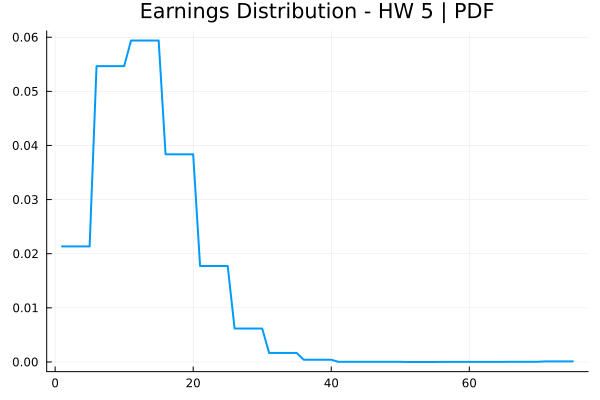

In [6]:
plot(1:(length(a_grid)*length(l_grid)),earnings_pdf, legend=false, title = "Earnings Distribution - HW 5 | PDF",lw=2)

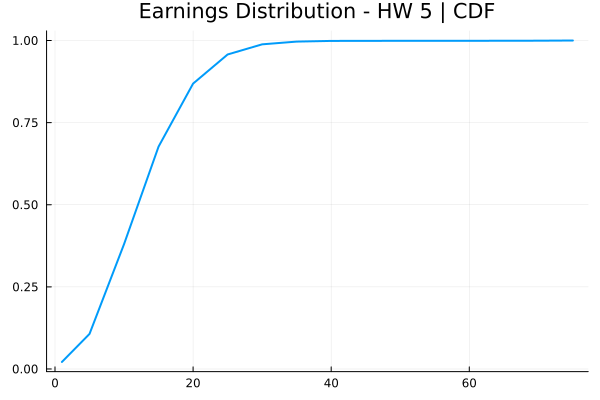

In [7]:
# CDF
earnings_cdf = cumsum(earnings_pdf)
plot(1:(length(a_grid)*length(l_grid)),earnings_cdf, legend=false, title = "Earnings Distribution - HW 5 | CDF",lw=2)

---
Item (a)

Now let's move to the data from IPUMS CPS. I picked the Annual Social and Economic Supplement (ASEC) of the Current Population Survey (CPS) for 2024. I chose this dataset as it provides detailed income data for individuals, including wages, earnings, transfers, etc. Moreover, it is the main source for the official U.S. poverty statistics. Since there is no unemployment in the Aiyagari model, I just consider data information on people who are in the labor force.

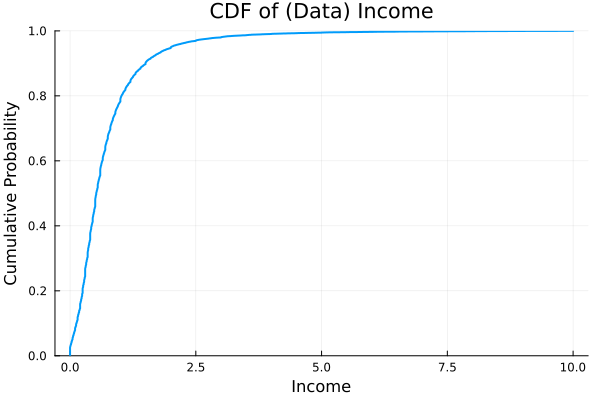

In [8]:
# Data collected and filtered with the help of Ethan Cohen!
data = CSV.File(GzipDecompressorStream(open("cps3.csv.gz"))) |> DataFrame;

data = @chain data begin
    @select(INCTOT, LABFORCE) 
    @filter(INCTOT < 999999998, INCTOT >= 0)
    @filter(LABFORCE .== 2)
    @mutate(inc_thousands = INCTOT / 100000)
    @filter(inc_thousands <= 10)
    @select(inc_thousands)
end;

sorted_income = sort(data.inc_thousands)
n = length(sorted_income)
cumulative_prob = collect(1:n) ./ n

plot(sorted_income, cumulative_prob, xlabel="Income", ylabel="Cumulative Probability", title="CDF of (Data) Income", ylims=(0,1), legend=false, lw=2)


Item (b)

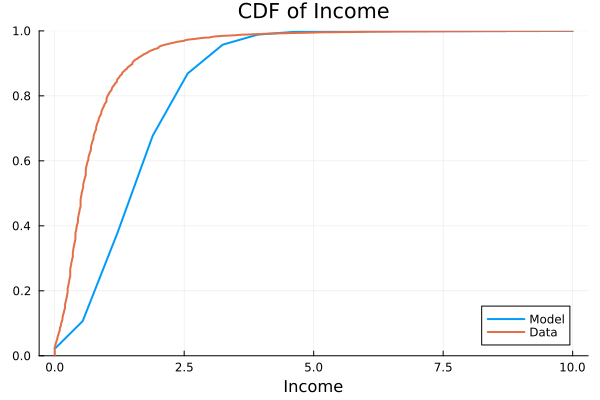

In [9]:
# Define the new x-axis values that span from 0 to 10
x_values = LinRange(0, 10, length(a_grid) * length(l_grid))

# Plot the CDF of the model
plot(x_values, earnings_cdf, legend=true, title="CDF of Income", xlabel="Income", label="Model", ylims=(0, 1), lw=2)

# Overlay the data on the same plot
plot!(sorted_income, cumulative_prob, label="Data", lw=2)


As we can notice, both the CDF in the model and in the Data have a similar shape. However, it seems that the data is more concentrated in the lower end.

---
Item (c):

Robustness: decrease intertemporal elasticity of substitution to $\mu = 0.2$. 

In [12]:
β = 0.95; # discount factor
δ = 0.04; # depreciation rate
α = 0.33; # output elasticity of capital:: Cobb-Douglas
μ = 0.2; # relative risk aversion coefficient
γ = 50000; # parameter for penalty function:::: it's a little of an overkill, could be smaller
ϕ = 0; # borrowing constraint

a_lb = ϕ;
a_ub = 4;
n = 20;
a_grid = LinRange(a_lb,a_ub,n);

# Values for prices (guesses)
r_max = (1/β)-1; # maximum interest rate
r_g = 0.8*r_max; # guess for interest rate
w_g = (1-α)*(α/(r_g+δ))^(α/(1-α)); # guess for wage

# Psi function::: same idea as HW 4
function psi(i,a,grid_a)
    n = length(grid_a);
    if i == 1
        if a >= grid_a[i] && grid_a[i+1] >= a
            ψ = (grid_a[i+1] - a)/(grid_a[i+1] - grid_a[i]);
        else        
            ψ = 0;
        end
        
    elseif i == n   
        if a >= grid_a[i-1] && grid_a[i] >= a    
            ψ = (a - grid_a[i-1])/(grid_a[i] - grid_a[i-1]);
        else        
            ψ = 0;        
        end
        
    else        
        if a >= grid_a[i-1] && grid_a[i] >= a            
            ψ = (a - grid_a[i-1])/(grid_a[i] - grid_a[i-1]);            
        elseif a > grid_a[i] && grid_a[i+1] >= a
            ψ = (grid_a[i+1] - a)/(grid_a[i+1] - grid_a[i]);           
        else 
            ψ = 0;           
        end        
    end

    return ψ
end

# Function to compute the assets for tomorrow
function asset(θ,x,y)

    idx_labor = findfirst(z -> z == y, l_grid); # get the index (position in the grid) in the of the labor endowment
    
    a = 0;
    for i=1:n
        a += θ[i,idx_labor]*psi(i,x,a_grid) # compute assets for tomorrow using the approximation
    end
   
    return a
 end

 # Function to compute the residual
 function residuals(θ,k,l)

    idx_labor = findfirst(z -> z==l,l_grid);
    c(x,y) = w_g*y + (1+r_g)*x - asset(θ,x,y); # function that computes consumption today
    aux1 = (c(k,l))^(-μ) - γ*min(asset(θ,k,l),0)^2; # first part of residual equation
    aux2 = 0;
    for i=1:N
        aux2 += T[idx_labor,i]*(c(asset(θ,k,l),l_grid[i]))^(-μ); # second part of residual equation
    end
    # Residual
    R = aux1 - β*(1+r_g)*aux2; # residual equation

    return R
 end

# Function to solve the integral using quadratures
function quadrature(f,start,endd,n)

    d = n-1;
    delta = (endd-start)/(n-1);
    quad_pts = zeros(n);
    quad_wght = zeros(n);
    for i=1:n   
        quad_pts[i] = start + (i-1)*delta;
    end

    quad_wght[1] = delta/2;
    quad_wght[n] = delta/2;
    
    for i=2:d
        quad_wght[i] = delta;
    end

    intt = 0;
    for i=1:n
        intt += quad_wght[i]*f(quad_pts[i]);
    end

    return intt
end

# Function to build the weighted integral:
function weighted_integral(θ,i,j)
    
    sol = quadrature(x -> psi(i,x,a_grid)*residuals(θ,x,l_grid[j]),a_grid[1],a_grid[end],n); # galerkin 

    if sol == -Inf || isnan(sol)
        return -100
    else
        return sol
    end

end

# Function to compute optimal solution for θ using the newton-raphson method
function nrm(G,θ;tol=1e-10,max_iter=40)

    for iter in 1:max_iter

        residual = abs(sum(G(θ)));

        if residual <= tol
            return θ;
        end
   
        J = ForwardDiff.jacobian(G,θ);
        θ = reshape(vec(θ) - inv(J) * vec(G(θ)), n, N);

    end

    if abs(sum(G(θ))) <= tol
        return θ
    elseif abs(sum(G(θ))) > tol
        return θ
    end

end

root_fct = θ -> [weighted_integral(θ,i,j) for i in 1:n, j in 1:N]

θ = zeros(n,N);
for i=1:N
    θ[:,i] = 0.35*(w_g*l_grid[i] .+ (1 + r_g)*a_grid);
end

#θ_opt = nrm(root_fct, θ, tol=1e-6);
solution = nlsolve(root_fct,θ);
θ_opt = solution.zero;

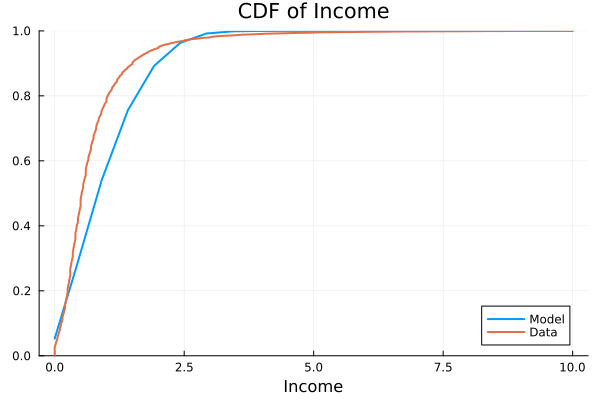

In [13]:
# Compute invarian distribution
Φ_2 = invariant(θ_opt, T, a_grid);

r = r_iter;
# Compute earnings for each asset-labor combination
earnings = [w * l_grid[j] + r * a_grid[i] for i in 1:length(a_grid), j in 1:length(l_grid)]

# Create a vector to store the earnings distribution (pdf)
earnings_pdf = zeros(length(a_grid) * length(l_grid))

# Populate the earnings_pdf by summing the probabilities for each earnings level
for i in 1:length(a_grid)
    for j in 1:length(l_grid)
        earnings_level = w * l_grid[j] + r * a_grid[i]

        # Convert 2D (i, j) indices to a 1D index
        idx = (i - 1) * length(l_grid) + j

        # Find the corresponding earnings level in the earnings_pdf and sum probabilities
        earnings_pdf[idx] += Φ_2[i, j]
    end
end

# CDF
earnings_cdf = cumsum(earnings_pdf);

x_values = LinRange(0, 10, length(a_grid) * length(l_grid))

# Plot the CDF of the model
plot(x_values, earnings_cdf, legend=true, title="CDF of Income", xlabel="Income", label="Model", ylims=(0, 1), lw=2)

# Overlay the data on the same plot
plot!(sorted_income, cumulative_prob, label="Data", lw=2)

As we can see, the fit is significantly improved. Recall that $\mu$ is the risk aversion coefficient, so by decreasing this parameter, we are essentially assuming that the agent is less risk-averse and therefore less concerned about future shocks. This reduced concern leads to lower savings and, consequently, lower capital income, which explains the higher concentration of income in the lower end of the distribution achieved with lower values of $\mu$.

Another way to interpret this is by noting that decreases in $\mu$ represent increases in the intertemporal elasticity of substitution (IES), meaning that agents are more flexible in shifting consumption between periods. With a higher IES, agents are more willing to tolerate periods of low consumption, which reduces the need for additional savings.